In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pylab as pl
import scipy.stats as st
import seaborn as sns
import pandas as pd
import detection as dtc
import fitting
import emission
from constants import *
import cross_sections as cs
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from math import gamma
from scipy.integrate import simps
from tqdm import tqdm
import os


Bad key text.latex.preview in file /home/pedroc/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /home/pedroc/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /home/pedroc/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default qualit

In [2]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [4]:
E = np.linspace(1, 100, 1000000) # Neutrino detection energy
detector = 'super-k'
resolution = 0.05 # Fraction of error in energy reconstruction
distance = 5 # kpc
if detector == 'super-k':
    targets = (32e9/18.01528)*6.022e23*2
elif detector == 'DUNE':
    targets = 6.03e32
elif detector == 'JUNO':
    targets = 1.5e33
elif detector == 'Hyper-k':
    targets = (216e9/18.01528)*6.022e23*2

In [5]:
ref = dtc.energy_sampler(E, 5e52, resolution, 'proportional', detector, 'normal', distance, phi = 0)
# ref_invert = dtc.energy_sampler(E, 5e52, resolution, 'proportional', detector, 'inverted', distance, phi = 0)


Number of expected neutrinos by flavor at 5 kpc (super-k)

electron neutrinos: 11258
electron antineutrinos: 32397
mu/tau (anti)neutrinos: 65


In [6]:
y, bins = np.histogram(ref['Total'], bins = [i for i in range(91)], density = True)

In [7]:
x = (bins[:-1] + bins[1:])/2

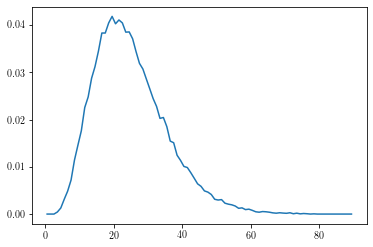

In [8]:
plt.plot(x, y)

In [9]:
f = fitting.fitting_spectra

In [15]:
def fitting_spectra(x, alpha, E_mean):
    """
    Shape of the detection spectrum
    """
    channels = ['ibd','nue_e','nuebar_e','nue_O16','nuebar_O16','numu_e',
                'numubar_e','nc_nue_O16','nc_nuebar_O16']
    xs_data = cs.snowglobes(channels)

    # All these cross sections are in units of 10⁻³⁸ cm²/MeV
    cs_ibd = interp1d(1e3*(10**(xs_data[0][0])), xs_data[0][4]/1e3)
    cs_nue_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[1][1]/1e3)
    cs_nuebar_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[2][4]/1e3)
    cs_nue_O16 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[3][1]/1e3)
    cs_nuebar_O16 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[4][1]/1e3)
    cs_nux_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[5][2]/1e3)
    cs_nuxbar_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[6][5]/1e3)
    cs_nc_nue_O16 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[7][1]/1e3)
    cs_nc_nuebar_O16 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[8][4]/1e3)
    # Total cross section
    total_cross = cs_nue_e(x)*x*1e-38 + cs_nue_O16(x)*x*1e-38 + cs_nc_nue_O16(x)*x*1e-38 + cs_nuebar_e(x)*x*1e-38 + cs_ibd(x)*x*1e-38 + cs_nuebar_O16(x)*x*1e-38 + cs_nc_nuebar_O16(x)*x*1e-38 + cs_nux_e(x)*x*1e-38 + cs_nuxbar_e(x)*x*1e-38
    # Detector efficiency
    eff = dtc.efficiency_sigmoid(x, 1, 7, 3.5)
    # Combined spectrum
    spectrum = fitting.spectrum_shape(x, alpha, E_mean)
    all = spectrum*total_cross*eff
    # Normalization
    A = simps(all, x)
    return all/A

In [16]:
c, cov = curve_fit(fitting_spectra, x, y)

In [17]:
c

array([ 2.15759052, 13.57212342])

In [22]:
cov

array([[0.00091888, 0.00166924],
       [0.00166924, 0.00342867]])

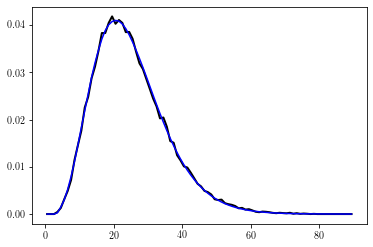

In [18]:
plt.plot(x, y, lw = 2, color = 'black')
plt.plot(x, fitting_spectra(x, *c), color = 'blue')

In [19]:
prior_params = np.array([[0,10],[0,20]], dtype=np.float64)

In [20]:
post = fitting.rejABC(f, x, y, prior_params, 7e-3, 10000)

100.00% of samples sorted. Elapsed time (h:m:s): 0:04:03.304422

In [21]:
n_bins = 40

repeat = 5

for l in range(repeat):
    p = post[np.where(post[:,-1] == np.min(post[:,-1]))[0][0]][:-1]
    p_std = np.std(post[:,:-1], axis=0) # Parameter error as standard deviation of posterior
    
    hist = np.zeros((len(p), n_bins))
    bins = np.zeros((len(p), n_bins+1))
    
    # Define new priors
    for k in range(len(hist)):
        hist[k], bins[k] = np.histogram(post[:, k], n_bins, density=True)
    eps = np.median(post[:,-1])
    post = fitting.smcABC(f, x, y, hist, bins, n_bins, p_std, eps, 50000, 10000)

64.00% of samples sorted. Elapsed time (h:m:s): 0:13:39.930952

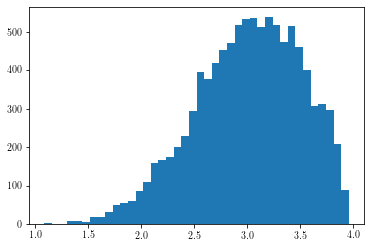

In [23]:
plt.hist(post[:,0], bins = 40)
plt.show()

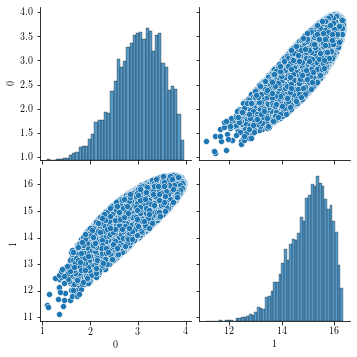

In [24]:
sns.pairplot(pd.DataFrame(post[:,:-1]))

100%|██████████| 2000/2000 [00:51<00:00, 38.57it/s]


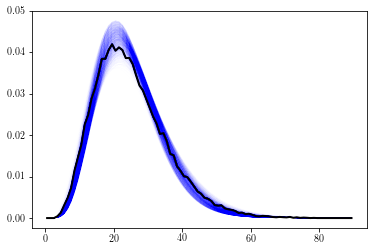

In [25]:
plt.plot(x, y, lw = 2, color = 'black')
for i in tqdm(range(int(len(post[:,0])/5))):
    plt.plot(x, f(x, post[i,0], post[i,1], 'super-k'), lw = 1,
             color = 'blue', alpha = 0.002)

plt.show()

In [103]:
pd.DataFrame(post).rename(columns={0: 'Alpha', 1: 'Mean energy', 2: 'Error'}).to_csv(f'Results/Alpha_and_E_mean_supernova_energy_per_flavor_5e52_distance_{distance}_detector_{detector}.csv')

## Loop with different distances

In [16]:
prior_params = np.array([[0,10],[0,20]], dtype=np.float64)
f = fitting.fitting_spectra

n_bins = 40
repeat = 5

for i in tqdm(range(40)):
    # print(f'\r Simulation {i+1} of 50', end="\n")
    distance = 5*(i+1) # kpc
    ref = dtc.energy_sampler(E, 5e52, resolution, 'proportional', detector, 'normal', distance,
                             phi = 0, print_expected = False)
    if len(ref['Total']) < 20:
        print(f'Muitos poucos neutrinos detectados. Distância: {distance} kpc')
        break
    y, bins = np.histogram(ref['Total'], bins = [i for i in range(91)], density = True)
    x = (bins[:-1] + bins[1:])/2
    post = fitting.rejABC(f, x, y, prior_params, 7e-3, 10000, print_progress = False)

    for l in range(repeat):
        p = post[np.where(post[:,-1] == np.min(post[:,-1]))[0][0]][:-1]
        p_std = np.std(post[:,:-1], axis=0) # Parameter error as standard deviation of posterior

        hist = np.zeros((len(p), n_bins))
        bins = np.zeros((len(p), n_bins+1))

        # Define new priors
        for k in range(len(hist)):
            hist[k], bins[k] = np.histogram(post[:, k], n_bins, density=True)
        eps = np.median(post[:,-1])
        post = fitting.smcABC(f, x, y, hist, bins, n_bins, p_std, eps, 50000, 10000, print_progress = False)
        
    pd.DataFrame(post).rename(columns={0: 'Alpha', 1: 'Mean energy', 2: 'Error'}).to_csv(f"Results/Alpha_and_E_mean_supernova_energy_per_flavor_5e52_distance_{distance}_detector_{detector}_total_detections_{len(ref['Total'])}.csv")

 92%|█████████▎| 37/40 [38:43:54<3:08:25, 3768.50s/it] 

Muitos poucos neutrinos detectados. Distância: 190 kpc


In [8]:
results = os.listdir('Results')

100%|██████████| 156/156 [00:06<00:00, 24.27it/s]


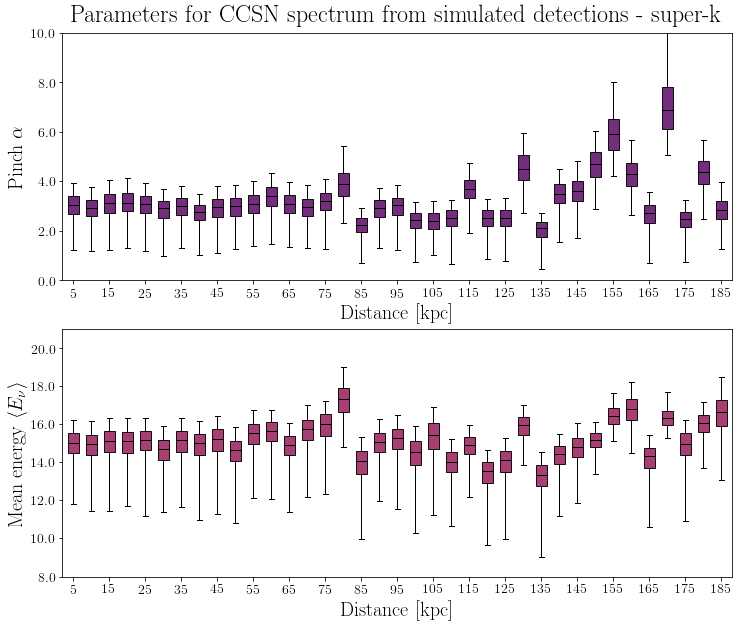

In [10]:
fig = plt.figure(figsize=(12,10))
ax0 = fig.add_subplot(211)
# ax1 = fig.add_subplot(212, polar=True)
ax1 = fig.add_subplot(212)
for i in tqdm(range(len(results))):
    d = results[i].split('_')[10]
    if results[i].split('_')[12] == detector:
        df = pd.read_csv(f'Results/{results[i]}')
    else:
        continue
    # df = pd.read_csv(f'Results/{results[i]}')
    ax0.boxplot(df['Alpha'], positions = [int(d)], widths = 3, patch_artist = True,
                          boxprops = {'facecolor': sns.color_palette('inferno')[1], 
                                      'edgecolor': 'black', 'alpha': 0.9},
                          whis = (0, 100), medianprops = {'color': 'black',
                                                         'linewidth': 1})
    # for pc in violin['bodies']:
    #     pc.set_facecolor('#D43F3A')
    #     pc.set_edgecolor('black')
    #     pc.set_alpha(0.8)

    ax1.boxplot(df['Mean energy'], positions = [int(d)], widths = 3, patch_artist = True,
                          boxprops = {'facecolor': sns.color_palette('inferno')[2],
                                      'edgecolor': 'black', 'alpha': 0.9},
                          whis = (0, 100), medianprops = {'color':'black', 'linewidth': 1})
    # violin = ax1.violinplot(df['Mean energy'], positions = [d], widths = 0.1, showextrema = False)
    # for pc in violin['bodies']:
    #     pc.set_facecolor('white')
    #     pc.set_edgecolor('black')
    #     pc.set_alpha(0.8)

ax0.set_xlim(2, 188)
ax0.set_ylim(0, 10)
ax0.set_xlabel('Distance [kpc]', fontsize = 20)
ax0.set_ylabel(r'Pinch $\alpha$', fontsize = 20)
ax0.set_xticks([5+10*i for i in range(19)])
ax0.set_xticklabels(ax0.get_xticks(), fontsize = 14)
ax0.set_yticklabels(ax0.get_yticks(), fontsize = 14)

ax1.set_xlim(2, 188)
ax1.set_ylim(8, 21)
ax1.set_xlabel('Distance [kpc]', fontsize = 20)
ax1.set_ylabel(r'Mean energy $\left \langle E_{\nu} \right \rangle$', fontsize = 20)
ax1.set_xticks([5+10*i for i in range(19)])
ax1.set_xticklabels(ax1.get_xticks(), fontsize = 14)
ax1.set_yticklabels(ax1.get_yticks(), fontsize = 14)

ax0.set_title(f'Parameters for CCSN spectrum from simulated detections - {detector}',
              fontsize = 24, pad = 10)

im = mpimg.imread(r"/home/pedroc/Documentos/pedro/Mestradives/Rodrigo_faro_transparente.png")
# im2 = mpimg.imread(r"/home/pedroc/Documentos/pedro/Mestradives/shrek.png")
im3 = mpimg.imread(r"/home/pedroc/Documentos/pedro/Mestradives/Explosion.png")
im4 = mpimg.imread(r"/home/pedroc/Documentos/pedro/Mestradives/ben10.png")
im5 = mpimg.imread(r"/home/pedroc/Documentos/pedro/Mestradives/duck.png")

# ax1.patch.set_color('indianred')
# ax1.set_title('\n''RECEBA', fontsize = 26)
# circle = plt.Circle((0, 0), 4, transform=ax1.transData._b, color="maroon", alpha=0.8)
# ax1.add_artist(circle)
# ax1.set_rlim(23, 8)
# ax1.grid(False)
# ax1.set_yticklabels([])
# plt.tight_layout()
# newax = fig.add_axes([0.14,0.086,0.383,0.383], anchor='NE', zorder=-1)
# newax.imshow(im)
# newax.axis('off')

# newax = fig.add_axes([0.42,0.25,0.07,0.07], anchor='NE', zorder=1)
# newax.imshow(im2)
# newax.axis('off')

# newax = fig.add_axes([0.35,0.168,0.3,0.3], anchor='NE', zorder=-1)
# newax.imshow(im3)
# newax.axis('off')
# newax = fig.add_axes([0.65,0.53,0.2,0.2], anchor='NE', zorder=-1)
# newax.imshow(im4)
# newax.axis('off')
# newax = fig.add_axes([0.1,0.528,0.1,0.1], anchor='NE', zorder=-1)
# newax.imshow(im5)
# newax.axis('off')
fig.patch.set_alpha(1)
for ax in fig.axes:
    ax.patch.set_alpha(1)
# plt.savefig(f'Plots/Results_alpha_E_mean_distances_{detector}.png',
#             dpi = 300, bbox_inches = 'tight')
plt.show()

# Distance estimation

In [15]:
# neutron star mass
m_ns = np.random.normal(1.33, 0.09)
# equation of state
eos = pd.read_csv('/home/pedroc/Documentos/pedro/Mestradives/Simulations/Neutron_eos_sly9.csv', sep = ';', header = None)
eos = eos.apply(lambda x: x.str.replace(',','.'))
eos = eos.rename(columns={0: 'Neutron Star Radius', 1: 'Neutron Star Mass'})
eos = eos.sort_values('Neutron Star Mass')
eos['Neutron Star Mass'] = eos['Neutron Star Mass'].astype('float')
eos['Neutron Star Radius'] = eos['Neutron Star Radius'].astype('float')
f = interp1d(eos['Neutron Star Mass'].values, eos['Neutron Star Radius'].values, fill_value = 'extrapolate')#, kind='cubic')

In [16]:
eos.head(5)

,Neutron Star Radius,Neutron Star Mass
34,16.661,0.20245
33,16.342,0.20245
32,15.942,0.20859
31,15.479,0.22086
30,15.048,0.23313


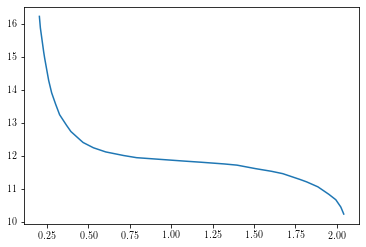

In [17]:
xnew = np.linspace(0.1, 2.1, 1000)

plt.plot(xnew, f(xnew))

In [18]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx

In [19]:
xnew = np.linspace(0.1, 2.1, 10000)

find_nearest(xnew, m_ns)

(1.3069206920692071, 6034)

In [20]:
radius = f(find_nearest(xnew, m_ns)[0])

\begin{align}
& L - \frac{G M_{\mathrm{NS}}^2}{R_{\mathrm{NS}}} \approx L = 3.6 \times 10^{53} \left( \frac{M_{\mathrm{NS}}}{1.5 M_\odot} \right)^2 \left( \frac{10 \mathrm{km}}{R_{\mathrm{NS}}} \right) \text{ ergs}
\end{align}

Shapiro, S. L., & Teukolsky, S. A. (2008). Black holes, white dwarfs, and neutron stars: The physics of compact objects. John Wiley & Sons.

In [21]:
L = 3.6e53*((m_ns/1.5)**2)*(10/radius)

In [22]:
L

2.3231829534947843e+53

In [23]:
def spectrum_shape(x, alpha, E_mean):
    """
    Overral shape of the emission spectrum
    """
    f_nu = (x**alpha)*np.exp(-(alpha + 1)*x/E_mean)
    return f_nu

In [30]:
if detector == 'super-k':
    channels = ['ibd','nue_e','nuebar_e','nue_O16','nuebar_O16','numu_e',
                'numubar_e','nc_nue_O16','nc_nuebar_O16']
    xs_data = cs.snowglobes(channels)

    # All these cross sections are in units of 10⁻³⁸ cm²/MeV
    cs_ibd = interp1d(1e3*(10**(xs_data[0][0])), xs_data[0][4]/1e3)
    cs_nue_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[1][1]/1e3)
    cs_nuebar_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[2][4]/1e3)
    cs_nue_O16 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[3][1]/1e3)
    cs_nuebar_O16 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[4][1]/1e3)
    cs_nux_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[5][2]/1e3)
    cs_nuxbar_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[6][5]/1e3)
    cs_nc_nue_O16 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[7][1]/1e3)
    cs_nc_nuebar_O16 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[8][4]/1e3)
    # Total cross section
    total_cross = cs_nue_e(x)*x*1e-38 + cs_nue_O16(x)*x*1e-38 + cs_nc_nue_O16(x)*x*1e-38 + cs_nuebar_e(x)*x*1e-38 + cs_ibd(x)*x*1e-38 + cs_nuebar_O16(x)*x*1e-38 + cs_nc_nuebar_O16(x)*x*1e-38 + cs_nux_e(x)*x*1e-38 + cs_nuxbar_e(x)*x*1e-38
elif detector == 'DUNE':
    channels = ['ibd','nue_e','nuebar_e','nue_Ar40','nuebar_Ar40','numu_e',
                'numubar_e','nc_nue_Ar40','nc_nuebar_Ar40','nc_numu_Ar40',
                'nc_numubar_Ar40']
    xs_data = cs.snowglobes(channels)

    # All these cross sections are in units of 10⁻³⁸ cm²/MeV
    cs_ibd = interp1d(1e3*(10**(xs_data[0][0])), xs_data[0][4]/1e3, fill_value='extrapolate')
    cs_nue_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[1][1]/1e3, fill_value='extrapolate')
    cs_nuebar_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[2][4]/1e3, fill_value='extrapolate')
    cs_nue_Ar40 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[3][1]/1e3, fill_value='extrapolate')
    cs_nuebar_Ar40 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[4][1]/1e3, fill_value='extrapolate')
    cs_nux_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[5][2]/1e3, fill_value='extrapolate')
    cs_nuxbar_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[6][5]/1e3, fill_value='extrapolate')
    cs_nc_nue_Ar40 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[7][1]/1e3, fill_value='extrapolate')
    cs_nc_nuebar_Ar40 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[8][4]/1e3, fill_value='extrapolate')
    cs_nc_nux_Ar40 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[9][2]/1e3, fill_value='extrapolate')
    cs_nc_nuxbar_Ar40 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[10][5]/1e3, fill_value='extrapolate')
    # Total cross section
    total_cross = cs_nue_e(x)*x*1e-38 + cs_nue_Ar40(x)*x*1e-38 + cs_nc_nue_Ar40(x)*x*1e-38 + cs_nuebar_e(x)*x*1e-38 + cs_ibd(x)*x*1e-38 + cs_nuebar_Ar40(x)*x*1e-38 + cs_nc_nuebar_Ar40(x)*x*1e-38 + cs_nux_e(x)*x*1e-38 + cs_nuxbar_e(x)*x*1e-38 + cs_nc_nux_Ar40(x)*x*1e-38 + cs_nc_nuxbar_Ar40(x)*x*1e-38
elif detector == 'JUNO':
    channels = ['ibd','nue_e','nuebar_e','nue_C12','nuebar_C12','numu_e',
                'numubar_e','nc_nue_C12','nc_nuebar_C12','nc_numu_C12',
                'nc_numubar_C12']
    xs_data = cs.snowglobes(channels)

    # All these cross sections are in units of 10⁻³⁸ cm²/MeV
    cs_ibd = interp1d(1e3*(10**(xs_data[0][0])), xs_data[0][4]/1e3, fill_value = (0,xs_data[0][1][-1]/1e3))
    cs_nue_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[1][1]/1e3, fill_value = (0,xs_data[1][1][-1]/1e3))
    cs_nuebar_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[2][4]/1e3, fill_value = (0,xs_data[2][4][-1]/1e3))
    cs_nue_C12 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[3][1]/1e3, fill_value = (0,xs_data[3][1][-1]/1e3))
    cs_nuebar_C12 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[4][1]/1e3, fill_value = (0,xs_data[4][1][-1]/1e3))
    cs_nux_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[5][2]/1e3, fill_value = (0,xs_data[5][2][-1]/1e3))
    cs_nuxbar_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[6][5]/1e3, fill_value = (0,xs_data[6][5][-1]/1e3))
    cs_nc_nue_C12 = interp1d(1e3*(10**(xs_data[7][0])), xs_data[7][1]/1e3, fill_value = 'extrapolate')
    cs_nc_nuebar_C12 = interp1d(1e3*(10**(xs_data[8][0])), xs_data[8][4]/1e3, fill_value = 'extrapolate')
    cs_nc_nux_C12 = interp1d(1e3*(10**(xs_data[9][0])), xs_data[9][2]/1e3, fill_value = 'extrapolate')
    cs_nc_nuxbar_C12 = interp1d(1e3*(10**(xs_data[10][0])), xs_data[10][5]/1e3, fill_value = 'extrapolate')
    # Number of target particles
    """"
    Fengpeng, A., Guangpeng, A. N., Qi, A. N., Antonelli, V., Baussan, E.,
    Beacom, J., ... & Sinev, V. (2016). Neutrino physics with JUNO.
    """
    n_target = 1.5e33
    # Total cross section
    total_cross = cs_nue_e(x)*x*1e-38 + cs_nue_C12(x)*x*1e-38 + cs_nc_nue_C12(x)*x*1e-38 + cs_nuebar_e(x)*x*1e-38 + cs_ibd(x)*x*1e-38 + cs_nuebar_C12(x)*x*1e-38 + cs_nc_nuebar_C12(x)*x*1e-38 + cs_nux_e(x)*x*1e-38 + cs_nuxbar_e(x)*x*1e-38 + cs_nc_nux_C12(x)*x*1e-38 + cs_nc_nuxbar_C12(x)*x*1e-38
elif detector == 'Hyper-k':
    channels = ['ibd','nue_e','nuebar_e','nue_O16','nuebar_O16','numu_e',
                'numubar_e','nc_nue_O16','nc_nuebar_O16']
    xs_data = cs.snowglobes(channels)

    # All these cross sections are in units of 10⁻³⁸ cm²/MeV
    cs_ibd = interp1d(1e3*(10**(xs_data[0][0])), xs_data[0][4]/1e3, fill_value='extrapolate')
    cs_nue_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[1][1]/1e3, fill_value='extrapolate')
    cs_nuebar_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[2][4]/1e3, fill_value='extrapolate')
    cs_nue_O16 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[3][1]/1e3, fill_value='extrapolate')
    cs_nuebar_O16 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[4][1]/1e3, fill_value='extrapolate')
    cs_nux_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[5][2]/1e3, fill_value='extrapolate')
    cs_nuxbar_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[6][5]/1e3, fill_value='extrapolate')
    cs_nc_nue_O16 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[7][1]/1e3, fill_value='extrapolate')
    cs_nc_nue_O16 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[7][1]/1e3, fill_value='extrapolate')
    cs_nc_nuebar_O16 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[8][4]/1e3, fill_value='extrapolate')
    # Number of target particles
    n_target = (216e9/18.01528)*6.022e23*2 # number of protons
    # Total cross section
    total_cross = cs_nue_e(x)*x*1e-38 + cs_nue_O16(x)*x*1e-38 + cs_nc_nue_O16(x)*x*1e-38 + cs_nuebar_e(x)*x*1e-38 + cs_ibd(x)*x*1e-38 + cs_nuebar_O16(x)*x*1e-38 + cs_nux_e(x)*x*1e-38 + cs_nuxbar_e(x)*x*1e-38 + cs_nc_nuebar_O16(x)*x*1e-38

The distance from the Supernova to the detector may be written as
\begin{align}
    D &= \displaystyle \sqrt{\frac{n_{\mathrm{tot}} L}{N_\nu^{\mathrm{tot}}} \int_0^\infty \mathcal{F}_{\mathrm{tot}}^d (E) \sigma(E) \varepsilon(E) dE} \approx \\
    &\approx \displaystyle \sqrt{3.6 \times 10^{53} \left( \frac{M_{\mathrm{NS}}}{1.5 M_\odot} \right)^2 \left( \frac{10 \mathrm{km}}{R_{\mathrm{NS}}} \right) \frac{n_{\mathrm{tot}}}{N_\nu^{\mathrm{tot}}} \int_0^\infty \mathcal{F}_{\mathrm{tot}}^d (E) \sigma(E) \varepsilon(E) dE}
\end{align}

where the mass of the neutron star is given by a normal distribution

\begin{align}
    M_{\mathrm{NS}} \sim \mathcal{N}(\mu=1.33, \sigma = 0.09)
\end{align}

and the radius is calculated from a equation of state

\begin{align}
    R_{\mathrm{NS}} = \mathrm{EOS} \left( M_{\mathrm{NS}} \right)
\end{align}

100%|██████████| 156/156 [01:20<00:00,  1.94it/s]


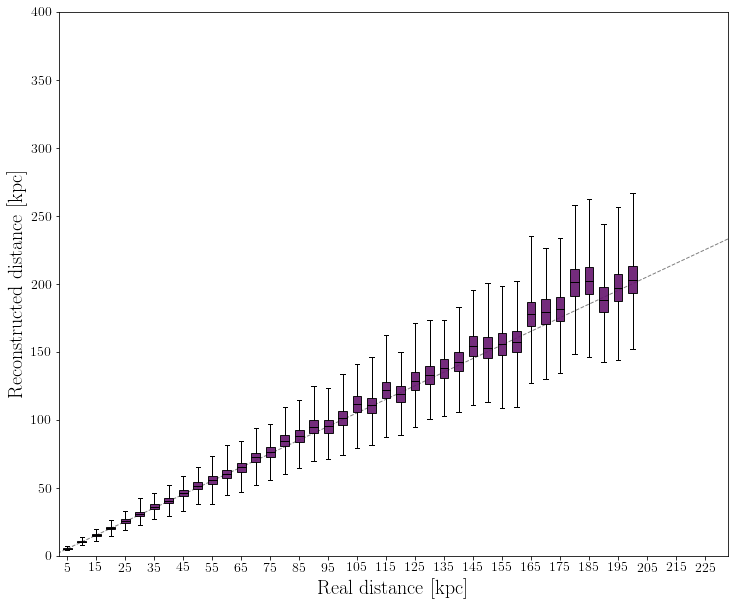

In [71]:
fig, ax = plt.subplots(figsize=(12,10))
plt.plot([0,235], [0,235], ls = '--', color = 'grey',
         lw = 1)
for i in tqdm(range(len(results))):
    d = results[i].split('_')[10]
    if 'detections' not in results[i].split('_'):
        continue
    else:
        if detector == results[i].split('_')[12]:
            N_T = int(results[i].split('_')[-1].split('.')[0])
            df = pd.read_csv(f'Results/{results[i]}')
            alphas = df['Alpha']
            E_mean = df['Mean energy']
        else:
            continue
        distances = []
        for i in range(len(alphas)):
            # Sampling neutron star mass
            m_ns = np.random.normal(1.33, 0.09)
            # Setting the radius
            radius = f(find_nearest(xnew, m_ns)[0])
            # Calculating total luminosity
            L = 3.6e53*((m_ns/1.5)**2)*(10/radius)
            # Calculating distance squared
            D = (L*6.2415e5/(24*np.pi*N_T))*targets*simps(fitting.spectrum_shape(x, alphas[i], E_mean[i])*dtc.efficiency_sigmoid(x, 1, 7, 3.5)*total_cross, x)
            distances.append(np.sqrt(D)*3.2408e-22)
        plt.boxplot(distances, positions = [int(d)], widths = 3, patch_artist = True,
                          boxprops = {'facecolor': sns.color_palette('inferno')[1], 
                                      'edgecolor': 'black', 'alpha': 0.9},
                          whis = (0, 100), medianprops = {'color': 'black',
                                                         'linewidth': 1})
        
plt.xlim(2, 233)
plt.ylim(0, 400)
plt.xlabel('Real distance [kpc]', fontsize = 20)
plt.ylabel(r'Reconstructed distance [kpc]', fontsize = 20)
plt.xticks([5+10*i for i in range(23)], [5+10*i for i in range(23)], fontsize = 14)
plt.yticks(ax.get_yticks(), fontsize = 14)
plt.show()

100%|██████████| 156/156 [01:20<00:00,  1.94it/s]


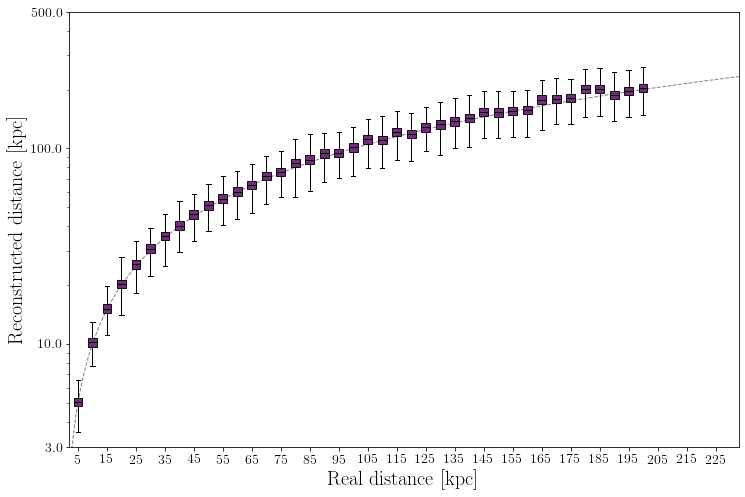

In [73]:
fig, ax = plt.subplots(figsize=(12,8))
x_d = np.linspace(2, 235, 10000)
plt.plot(x_d, x_d, ls = '--', color = 'grey',
         lw = 1)
for i in tqdm(range(len(results))):
    d = results[i].split('_')[10]
    if 'detections' not in results[i].split('_'):
        continue
    else:
        if detector == results[i].split('_')[12]:
            N_T = int(results[i].split('_')[-1].split('.')[0])
            df = pd.read_csv(f'Results/{results[i]}')
            alphas = df['Alpha']
            E_mean = df['Mean energy']
        else:
            continue
        distances = []
        for i in range(len(alphas)):
            # Sampling neutron star mass
            m_ns = np.random.normal(1.33, 0.09)
            # Setting the radius
            radius = f(find_nearest(xnew, m_ns)[0])
            # Calculating total luminosity
            L = 3.6e53*((m_ns/1.5)**2)*(10/radius)
            # Calculating distance squared
            D = (L*6.2415e5/(24*np.pi*N_T))*targets*simps(fitting.spectrum_shape(x, alphas[i], E_mean[i])*dtc.efficiency_sigmoid(x, 1, 7, 3.5)*total_cross, x)
            distances.append(np.sqrt(D)*3.2408e-22)
        plt.boxplot(distances, positions = [int(d)], widths = 3, patch_artist = True,
                          boxprops = {'facecolor': sns.color_palette('inferno')[1], 
                                      'edgecolor': 'black', 'alpha': 0.9},
                          whis = (0, 100), medianprops = {'color': 'black',
                                                         'linewidth': 1})
        
plt.xlim(2, 233)
plt.ylim(3e0, 5e2)
plt.yscale('log')
plt.xlabel('Real distance [kpc]', fontsize = 20)
plt.ylabel(r'Reconstructed distance [kpc]', fontsize = 20)
plt.xticks([5+10*i for i in range(23)], [5+10*i for i in range(23)], fontsize = 14)
plt.yticks([3e0, 1e1, 1e2, 5e2], [3e0, 1e1, 1e2, 5e2], fontsize = 14)
plt.show()

In [37]:
def R_th(M):
    M_sol = 1.989e30
    c = 2.98e8
    G = 6.67e-11
    return 2.9*M*M_sol*G/c**2

def R_sph(M):
    M_sol = 1.989e30
    return 10.4*((1000/716)**(2/3))*((M*M_sol/M_sol)**(1/3))

In [34]:
M_sol = 1.989e30 # kg
M = np.linspace(0, 4, 1000)*M_sol
G = 6.67e-11 # m^3 / kg^1 s^2
c = 2.98e8 # m/s
R_th = 2.9*M*G/c**2
R_schw = 2*M*G/c**2
R_sph = 10.4*((1000/716)**(2/3))*((M/M_sol)**(1/3))

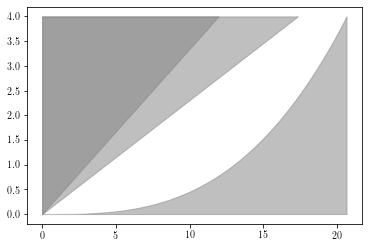

In [35]:
plt.fill_between(R_th/1000, M/M_sol, 4, color = 'grey', alpha = 0.5)
plt.fill_between(R_sph, 0, M/M_sol, color = 'grey', alpha = 0.5)
plt.fill_between(R_schw/1000, M/M_sol, 4, color = 'grey', alpha = 0.5)

100%|██████████| 156/156 [00:49<00:00,  3.13it/s]


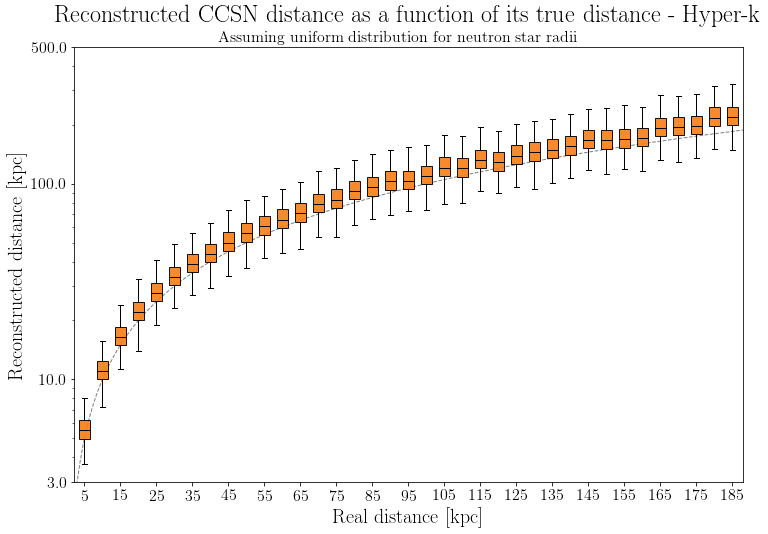

In [76]:
fig, ax = plt.subplots(figsize=(12,8))
x_d = np.linspace(2, 235, 10000)
plt.plot(x_d, x_d, ls = '--', color = 'grey',
         lw = 1)
for i in tqdm(range(len(results))):
    d = results[i].split('_')[10]
    if 'detections' not in results[i].split('_'):
        continue
    else:
        if detector == results[i].split('_')[12]:
            N_T = int(results[i].split('_')[-1].split('.')[0])
            df = pd.read_csv(f'Results/{results[i]}')
            alphas = df['Alpha']
            E_mean = df['Mean energy']
        else:
            continue
        distances = []
        for i in range(len(alphas)):
            # Sampling neutron star mass
            m_ns = np.random.normal(1.33, 0.09)
            # Setting the radius
            radius = np.random.uniform(R_th(m_ns)/1000, R_sph(m_ns))
            # Calculating total luminosity
            L = 3.6e53*((m_ns/1.5)**2)*(10/radius)
            # Calculating distance squared
            D = (L*6.2415e5/(24*np.pi*N_T))*targets*simps(fitting.spectrum_shape(x, alphas[i], E_mean[i])*dtc.efficiency_sigmoid(x, 1, 7, 3.5)*total_cross, x)
            distances.append(np.sqrt(D)*3.2408e-22)
        plt.boxplot(distances, positions = [int(d)], widths = 3, patch_artist = True,
                          boxprops = {'facecolor': sns.color_palette('inferno')[4], 
                                      'edgecolor': 'black', 'alpha': 0.9},
                          whis = (0, 100), medianprops = {'color': 'black',
                                                         'linewidth': 1})
        
plt.xlim(2, 188)
plt.ylim(3e0, 5e2)
plt.yscale('log')
plt.xlabel('Real distance [kpc]', fontsize = 20)
plt.ylabel(r'Reconstructed distance [kpc]', fontsize = 20)
plt.xticks([5+10*i for i in range(19)], [5+10*i for i in range(19)], fontsize = 16)
plt.yticks([3e0, 1e1, 1e2, 5e2], [3e0, 1e1, 1e2, 5e2], fontsize = 16)
plt.title(f'Reconstructed CCSN distance as a function of its true distance - {detector}', fontsize = 24,
         pad = 24)
fig.text(0.5, 0.89, 'Assuming uniform distribution for neutron star radii', ha = 'center', fontsize = 16)
fig.patch.set_alpha(1)
plt.savefig(f'Plots/Reconstructed_distance_model_independent_{detector}.svg', dpi = 300,
            bbox_inches = 'tight')
plt.show()

0 super-k 24


100%|██████████| 156/156 [01:00<00:00,  2.60it/s]


1 Hyper-k 30


100%|██████████| 156/156 [00:55<00:00,  2.83it/s]


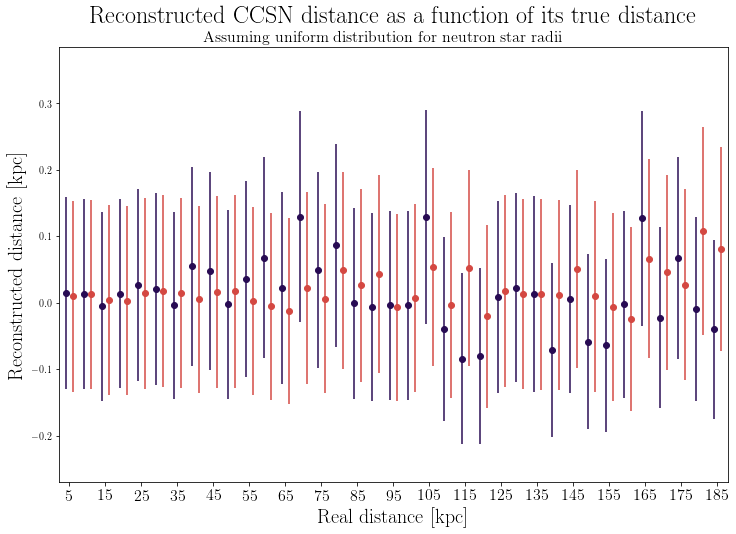

In [120]:
fig, ax = plt.subplots(figsize=(12,8))
x_d = np.linspace(2, 235, 10000)
# plt.plot(x_d, x_d, ls = '--', color = 'grey',
#          lw = 1)

detectors = ['super-k', 'Hyper-k']
for idx, detector in enumerate(detectors):
    if detector == 'Hyper-k':
        m = 30
        targets = (216e9/18.01528)*6.022e23*2
    else:
        m = 24
        targets = (32e9/18.01528)*6.022e23*2
    print(idx, detector, m)
    for i in tqdm(range(len(results))):
        d = results[i].split('_')[10]
        if 'detections' not in results[i].split('_'):
            continue
        else:
            if detector == results[i].split('_')[12]:
                N_T = int(results[i].split('_')[-1].split('.')[0])
                df = pd.read_csv(f'Results/{results[i]}')
                alphas = df['Alpha']
                E_mean = df['Mean energy']
            else:
                continue
            distances = []
            for j in range(len(alphas)):
                # Sampling neutron star mass
                m_ns = np.random.normal(1.33, 0.09)
                # Setting the radius
                radius = np.random.uniform(R_th(m_ns)/1000, R_sph(m_ns))
                # Calculating total luminosity
                L = 3.6e53*((m_ns/1.5)**2)*(10/radius)
                # Calculating distance squared
                D = (L*6.2415e5/(m*np.pi*N_T))*targets*simps(fitting.spectrum_shape(x, alphas[j], E_mean[j])*dtc.efficiency_sigmoid(x, 1, 7, 3.5)*total_cross, x)
                distances.append(np.sqrt(D)*3.2408e-22)
            distances = np.array(distances)
            # plt.boxplot((distances-int(d))/int(d), positions = [int(d)-1.5 + 3*idx], widths = 1.5, patch_artist = True,
            #                   boxprops = {'facecolor': sns.color_palette('inferno')[idx*2], 
            #                               'edgecolor': 'black', 'alpha': 0.9},
            #                   whis = (0, 100), medianprops = {'color': 'black',
            #                                                  'linewidth': 1})
            plt.scatter(int(d)-1 + 2*idx, np.mean((distances-int(d))/int(d)),
                        color = sns.color_palette('inferno')[idx*3])
            plt.errorbar(int(d)-1 + 2*idx, np.mean((distances-int(d))/int(d)),
                         yerr = np.std((distances-int(d))/int(d)), fmt = 'none',
                         color = sns.color_palette('inferno')[idx*3])
        
plt.xlim(2, 188)
# plt.ylim(3e0, 5e2)
# plt.yscale('log')
plt.xlabel('Real distance [kpc]', fontsize = 20)
plt.ylabel(r'Reconstructed distance [kpc]', fontsize = 20)
plt.xticks([5+10*i for i in range(19)], [5+10*i for i in range(19)], fontsize = 16)
# plt.yticks([3e0, 1e1, 1e2, 5e2], [3e0, 1e1, 1e2, 5e2], fontsize = 16)
plt.title(f'Reconstructed CCSN distance as a function of its true distance', fontsize = 24,
          pad = 24)
fig.text(0.5, 0.89, 'Assuming uniform distribution for neutron star radii', ha = 'center', fontsize = 16)
fig.patch.set_alpha(1)
# plt.savefig(f'Plots/Reconstructed_distance_model_independent_{detector}.svg', dpi = 300,
#             bbox_inches = 'tight')
plt.show()